In [1]:
import torch
import torch.nn as nn

import pandas
import numpy
import matplotlib.pyplot as plt

import random


In [2]:
def generate_real() -> torch.Tensor:
    """生成真实数据的生成器

    Returns:
        torch.Tensor: 生成接近1,0,1,0的随机数
    """
    real_data = torch.Tensor([
        random.uniform(0.8, 1.0),
        random.uniform(0.0, 0.2),
        random.uniform(0.8, 1.0),
        random.uniform(0.0, 0.2),
    ])
    return real_data

In [3]:
class Discriminator(nn.Module):
    # 分类器

    def __init__(self):
        
        # 初始化PyTorch父类
        super().__init__()
        
        # 定义神经网络层
        self.model = nn.Sequential(
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )
        
        # 创建损失函数
        self.loss_function = nn.MSELoss()
        
        # 创建优化器, 使用随机梯度下降
        self.optimiser = torch.optim.SGD(self.parameters(),lr=0.01)
        
        # 计数器和进程记录        
        self.counter = 0        
        self.progress = []


    def forward(self, inputs):
        # 直接运行模型
        return self.model(inputs)

    
    def train(self, inputs, targets):
        # 计算网络的输出
        outputs = self.forward(inputs)
        
        # 计算损失值
        loss = self.loss_function(outputs, targets)
        
        # 每训练10次增加计数器
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            
        # 归零梯度，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.3, 
            marker='.', grid=True, yticks=(0, 0.25, 0.5))


In [4]:
def generate_random(size) -> torch.Tensor:
    """生成随机数给上面分类器做测试

    Args:
        size (_type_): _description_

    Returns:
        torch.Tensor: _description_
    """
    random_data = torch.rand(size)
    return random_data

In [5]:
D = Discriminator()

for i in range(10000):
    # 真实数据
    D.train(generate_real(), torch.Tensor([1.0]))
    # 随机数
    D.train(generate_random(4), torch.Tensor([0.0]))


counter =  10000
counter =  20000


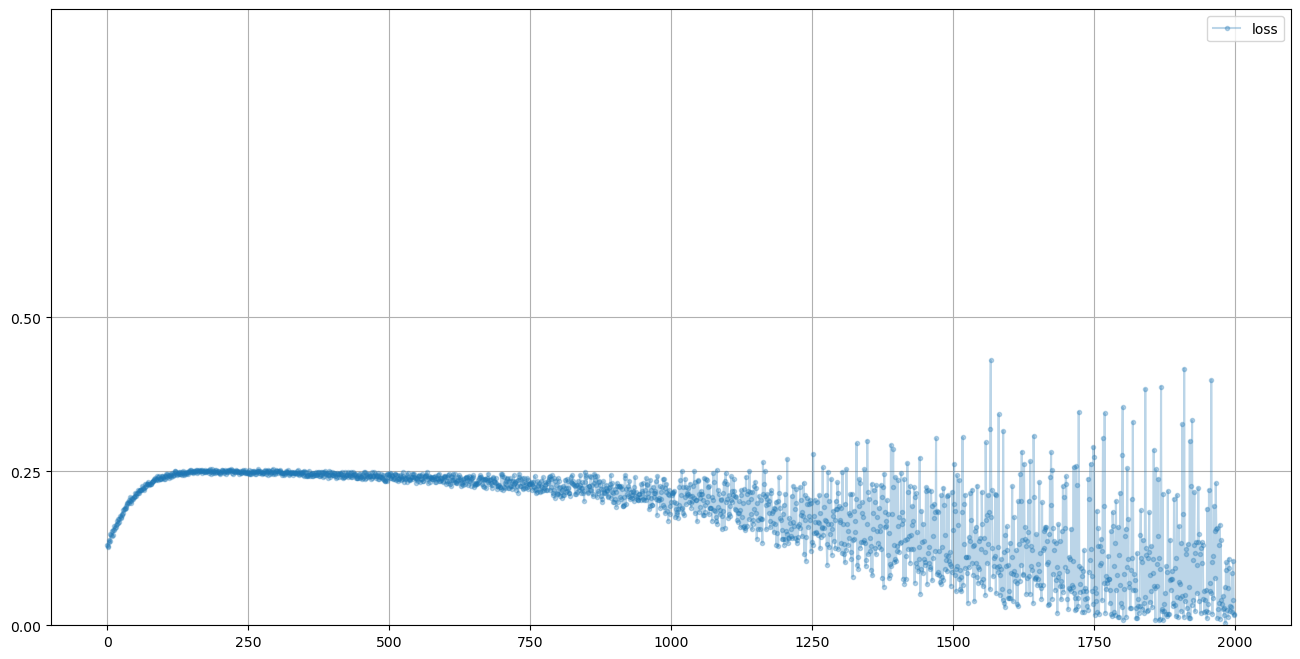

In [6]:
D.plot_progress()

用真实值带入，结果接近1

In [7]:
D.forward(generate_real())

tensor([0.7313], grad_fn=<SigmoidBackward0>)

用随机数带入，结果接近0

In [8]:
D.forward(generate_random(4))

tensor([0.2418], grad_fn=<SigmoidBackward0>)

In [9]:
class Generator(nn.Module):
    # 生成器

    def __init__(self):
        
        # 初始化PyTorch父类
        super().__init__()
        
        # 定义神经网络层
        self.model = nn.Sequential(
            nn.Linear(1, 3),
            nn.Sigmoid(),
            nn.Linear(3, 4),
            nn.Sigmoid()
        )
        
        # 创建优化器, 使用随机梯度下降
        self.optimiser = torch.optim.SGD(self.parameters(),lr=0.01)
        
        # 计数器和进程记录        
        self.counter = 0        
        self.progress = []




    def forward(self, inputs):
        # 直接运行模型
        return self.model(inputs)

    
    def train(self, D, inputs, targets):
        # 计算网络的输出
        g_output = self.forward(inputs)
        
        # 输入鉴别器
        d_output = D.forward(g_output)
        # 计算损失
        loss = D.loss_function(d_output, targets)
        
        # 每训练10次增加计数器
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())


        # 归零梯度，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()


    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.3, 
            marker='.', grid=True, yticks=(0, 0.25, 0.5))

In [10]:
G = Generator()
G.forward(torch.Tensor([0.5]))

tensor([0.6470, 0.6898, 0.6240, 0.5500], grad_fn=<SigmoidBackward0>)

In [11]:
D = Discriminator()
G = Generator()

image_list = []

for i in range(10000):

    # 先用真实样本训练
    D.train(generate_real(), torch.Tensor([1.0]))

    # 使用生成器样本训练鉴别器
    # 仅训练鉴别器不训练生成器，所以切断了计算图
    D.train(G.forward(torch.Tensor([0.5])).detach(), torch.Tensor([0.0]))

    # 训练生成器
    G.train(D, torch.Tensor([0.5]), torch.Tensor([1.0]))

    # 每训练1000次记录图像
    if (i % 1000 == 0):
        image_list.append(G.forward(torch.FloatTensor([0.5])).detach().numpy())

counter =  10000
counter =  20000


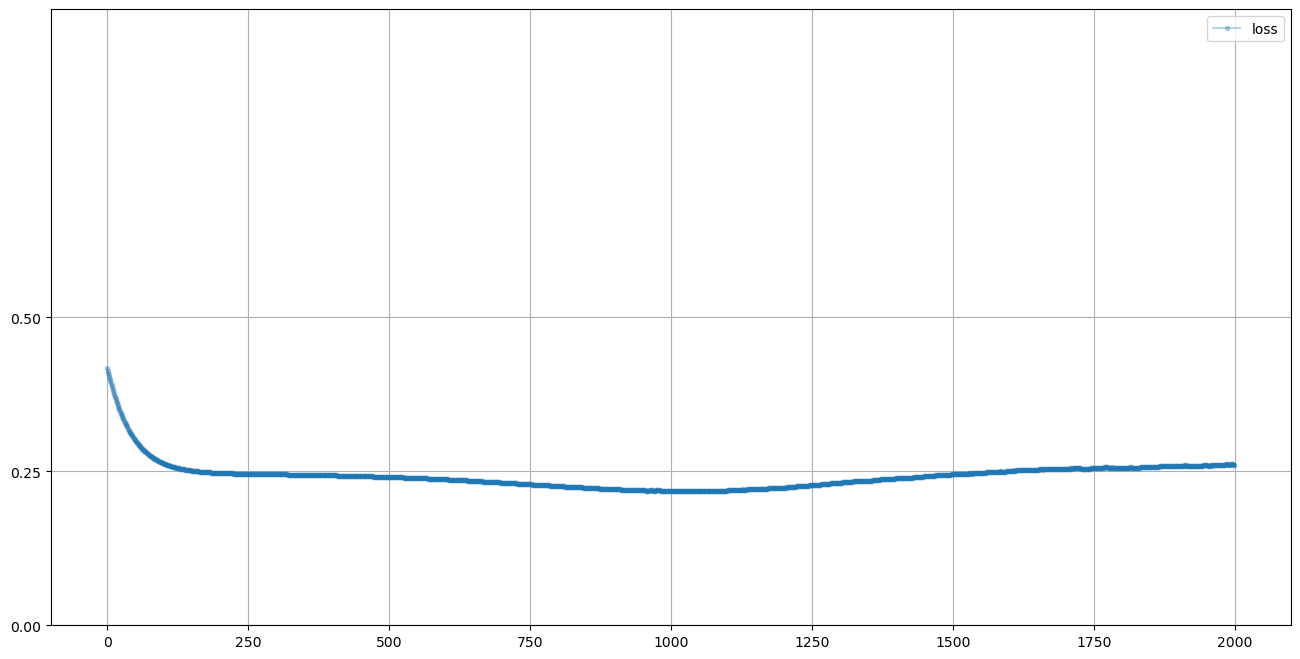

In [12]:
D.plot_progress()

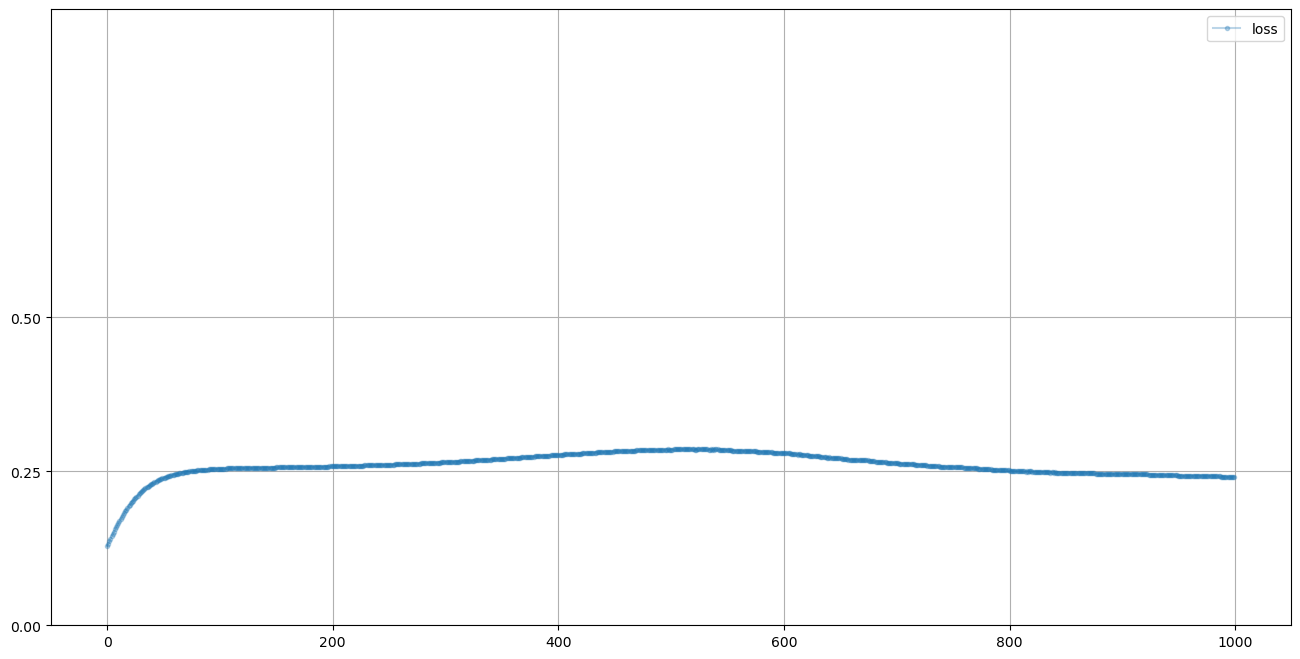

In [13]:
G.plot_progress()

In [14]:
G.forward(torch.Tensor([1]))

tensor([0.9257, 0.0763, 0.8926, 0.0491], grad_fn=<SigmoidBackward0>)

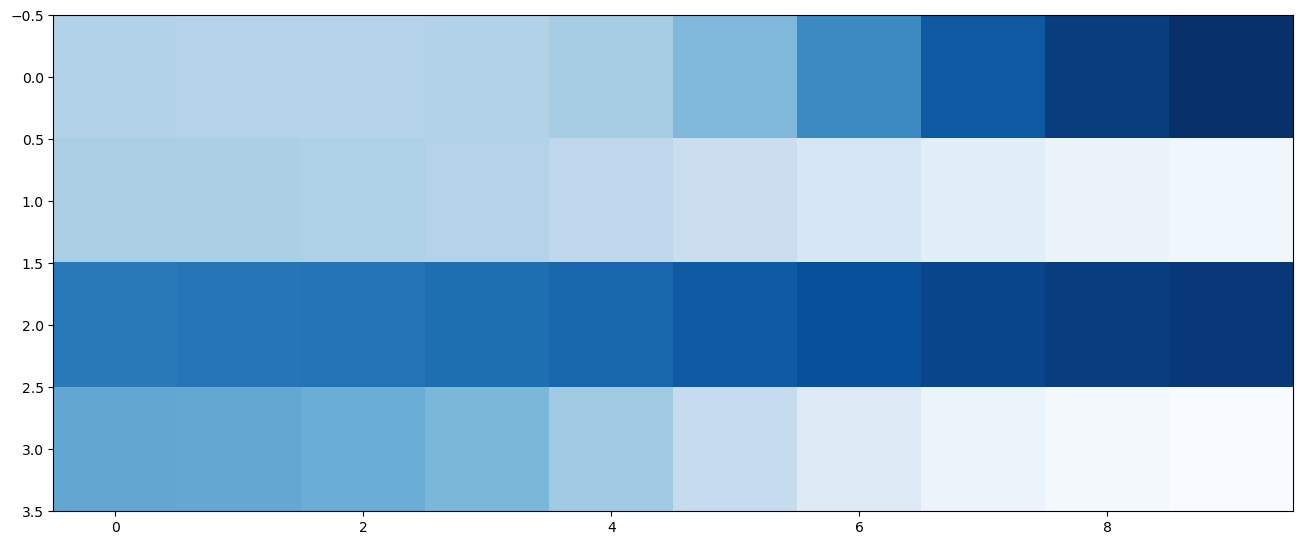

In [15]:
# plot images collected during training

plt.figure(figsize = (16,8))

plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')

In [16]:
image_list

[array([0.32458672, 0.34472427, 0.66537243, 0.5056299 ], dtype=float32),
 array([0.3197262 , 0.34004906, 0.67312235, 0.5020963 ], dtype=float32),
 array([0.31808782, 0.33280396, 0.68366766, 0.48455134], dtype=float32),
 array([0.32460836, 0.319137  , 0.7008159 , 0.44541186], dtype=float32),
 array([0.35480934, 0.2933833 , 0.72769135, 0.3715776 ], dtype=float32),
 array([0.44150415, 0.25080112, 0.76344234, 0.26648626], dtype=float32),
 array([0.60808116, 0.19733378, 0.8004213 , 0.17083307], dtype=float32),
 array([0.7689958 , 0.14896715, 0.83153516, 0.11118998], dtype=float32),
 array([0.8581115 , 0.11399122, 0.8562238 , 0.07852513], dtype=float32),
 array([0.90250987, 0.09084294, 0.8759007 , 0.06010114], dtype=float32)]